For the reproduction of results presented in: Neural network – based analysis of multimodal bond distributions using their EXAFS spectra
Submitted to PRL

Nicholas Marcella1* , Stephen Lam,2 Vyacheslav Bryantsev,3 Santanu Roy3 and Anatoly I. Frenkel4,5*
1 Department of Chemistry, University of Illinois, Urbana, Illinois 61801, United States
2 Department of Chemical Engineering, University of Massachusetts Lowell, Lowell, Massachusetts 01854, United States
3 Chemical Sciences Division, Oak Ridge National Laboratory, Oak Ridge, Tennessee 37830, United States
4 Department of Materials Science and Chemical Engineering, Stony Brook University, Stony Brook, New York 11794, United States
5 Chemistry Division, Brookhaven National Laboratory, Upton, New York 11973, United States

Contact: nmarcella@bnl.gov, nmarcella.sbu@gmail.com



# Functions

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numpy import trapz
from scipy import stats
from scipy.stats import norm

In [2]:
def integrate_mono(rdf ,rmesh, rrange):
    x,y = np.asarray([l for l in np.asarray([rmesh, rdf]).transpose() if rrange[0]<l[0]<rrange[1]]).transpose()
    return trapz(y,x)

In [7]:
def make_distro_norm(lower, uper, mu, sigma):
    return stats.norm(loc=mu, scale=sigma)

In [29]:
dimer_mesh = np.arange(0,6,.01)
rmesh = np.arange(0,6,.01)

In [9]:
kspace = np.linspace(0,12, num=100)

def chi_r(r):
    return np.asarray(list(map(lambda k: (1/r**2)*np.sin(2*k*r), kspace)))

In [4]:
def make_Fexafs(distances):
    digitized =np.digitize(distances
        , dimer_mesh)
    min_d=min(distances)
    max_d=max(distances)
    unique, counts = np.unique(digitized, return_counts=True)
    counter = [0]*len(dimer_mesh)
    for i in range(len(unique)):
        counter[unique[i]-1] = counts[i]/0.01
    integrated=integrate_mono(np.asarray(counter), dimer_mesh, [min_d,max_d])
    return [np.sum(np.array(list(map(lambda r: chi_r(r), distances))),axis=0)*integrate_mono(np.asarray(counter)/integrated, dimer_mesh, [min_d,max_d])/len(distances), np.asarray(counter)/integrated]

In [14]:
def generate_exafs_rdf(num_examples, mean1=2, sd1=0.2, mean2=3, sd2=0.1, rvs=1000):
    """
    Generates EXAFS and RDF using two normal distributions.

    :param num_examples: The number of examples to generate.
    :param mean1: Mean for the first normal distribution.
    :param sd1: Standard deviation for the first normal distribution.
    :param mean2: Mean for the second normal distribution.
    :param sd2: Standard deviation for the second normal distribution.
    :param rvs: Random variate parameter for the normal distribution.
    :yield: A tuple containing EXAFS and RDF.
    """
    for _ in range(num_examples):
        current_mean1 = np.random.uniform(mean1*0.5, mean1*1.5)
        current_sd1 = np.random.uniform(sd1*0.5, sd1*1.5)
        current_mean2 = np.random.uniform(mean2*0.5, mean2*1.5)
        current_sd2 = np.random.uniform(sd2*0.5, sd2*1.5)
        
        dist1 = norm(loc=current_mean1, scale=current_sd1)
        dist2 = norm(loc=current_mean2, scale=current_sd2)

        distances = np.concatenate((dist1.rvs(rvs), dist2.rvs(rvs)), axis=0)
        
        # make sure make_Fexafs is defined somewhere or imported
        exafs, rdf = make_Fexafs(distances)
        
        yield exafs, rdf

# Generate Training Data

In [10]:
all_exafs=[]
all_rdf=[]
for i in range(10000):
    min_r=np.random.uniform(1.5,5)
    max_r=min_r+1
    mean_r=np.random.uniform(min_r,max_r)
    distances=make_distro_norm(min_r,max_r,mean_r,np.random.uniform(.01,.5)).rvs(1000)
    exafs, rdf = make_Fexafs(distances)
    all_exafs.append(exafs)
    all_rdf.append(rdf)

# Import Training data

In [24]:
with open('.\\Data_pkl\\all_rdf.pickle', 'rb') as handle:
    all_rdf = pickle.load(handle)
    
with open('.\\Data_pkl\\all_exafs.pickle', 'rb') as handle:
    all_exafs = pickle.load(handle)

all_exafs=np.asarray(all_exafs)
all_rdf=np.asarray(all_rdf)

# Generate Test Data

In [15]:
x_test = []
y_test = []

# Generates 500 examples
for i in range(50):
    r_mean = np.random.uniform(1, 6)
    r_sd = np.random.uniform(0.1, 0.5)
    r_mean2 = np.random.uniform(1, 6)
    r_sd2 = np.random.uniform(0.1, 0.5)
    for exafs, rdf in generate_exafs_rdf(10, mean1=2, sd1=0.2, mean2=3, sd2=0.1):
        x_test.append(exafs)
        y_test.append(rdf)

# Convert lists to arrays if necessary
x_test = np.array(x_test)
y_test = np.array(y_test)

x_test_rs = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Load Test Data

In [32]:
x_test_rs = pickle.load(open('.\\Data_pkl\\x_test_rs.pickle', 'rb'))
y_test = pickle.load(open('.\\Data_pkl\\y_test.pickle', 'rb'))

# Training

In [21]:
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)


from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [22]:
def baseline_model():    
    i = Input(shape=(100,1))
    x1=Reshape((100,))(i)
    x2=Dense(516, activation='selu')(x1)
    x3=Dropout(.2)(x2)
    x4=Dense(516, activation='selu')(x3)
    x5=Dropout(.1)(x4)
    x6=Dense(516, activation='selu')(x5)
    o = Dense(600)(x6)
    model = Model(i, o)
    print("after building :",tf.executing_eagerly())
    model.compile( 
                  loss = 'mse', run_eagerly = True
                  , optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, clipnorm=1.0))
    print("after compile :",tf.executing_eagerly())
    return model

model = baseline_model()

after building : True
after compile : True


c:\Users\nickj\miniconda3\envs\Xron_ML_Ovito\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the path for the best weights
best_weights_path = ".\\training_weights_example\\best_weights.ckpt"

# Create a ModelCheckpoint callback to save the best weights
checkpoint_callback = ModelCheckpoint(filepath=best_weights_path,
                                      save_best_only=True,
                                      monitor='val_loss',
                                      mode='min',
                                      verbose=0)

if os.path.exists(best_weights_path):
    shutil.rmtree(best_weights_path)

try:

    batch_size = 64
    steps_per_epoch = int(10000 / batch_size)
    model.fit(all_exafs.reshape(all_exafs.shape[0], all_exafs.shape[1], 1) , all_rdf, batch_size=batch_size, epochs=100, steps_per_epoch=steps_per_epoch, validation_data= (x_test_rs, y_test), callbacks=[checkpoint_callback], verbose=0)

except KeyboardInterrupt:
    print("\nInterrupted by user. Loading best weights and stopping training.")
    model.load_weights(best_weights_path)

INFO:tensorflow:Assets written to: .\training_weights_example\best_weights.ckpt\assets
INFO:tensorflow:Assets written to: .\training_weights_example\best_weights.ckpt\assets
INFO:tensorflow:Assets written to: .\training_weights_example\best_weights.ckpt\assets
INFO:tensorflow:Assets written to: .\training_weights_example\best_weights.ckpt\assets
INFO:tensorflow:Assets written to: .\training_weights_example\best_weights.ckpt\assets
INFO:tensorflow:Assets written to: .\training_weights_example\best_weights.ckpt\assets
INFO:tensorflow:Assets written to: .\training_weights_example\best_weights.ckpt\assets
INFO:tensorflow:Assets written to: .\training_weights_example\best_weights.ckpt\assets
INFO:tensorflow:Assets written to: .\training_weights_example\best_weights.ckpt\assets
INFO:tensorflow:Assets written to: .\training_weights_example\best_weights.ckpt\assets
INFO:tensorflow:Assets written to: .\training_weights_example\best_weights.ckpt\assets
INFO:tensorflow:Assets written to: .\traini

# Load Model

In [35]:
model = keras.models.load_model('.\\Data_pkl\\model')

# Multimodal

1/1 [==============================] - 0s 72ms/step


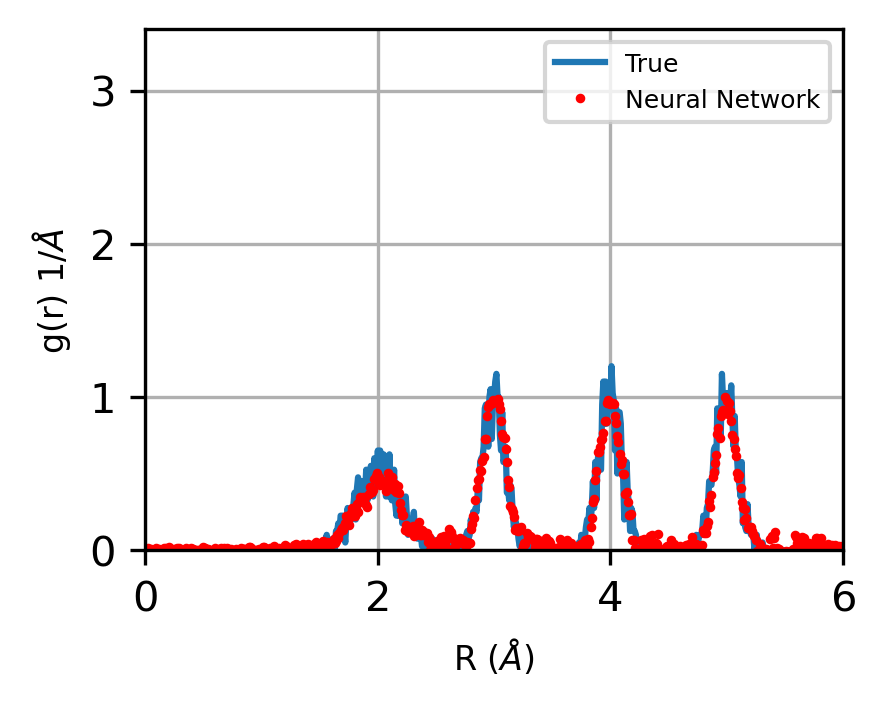

In [36]:
distances=np.concatenate((make_distro_norm(1,4,2,.2).rvs(1000),make_distro_norm(1,6,5,.1).rvs(1000),make_distro_norm(1,6,4,.1).rvs(1000),make_distro_norm(1,6,3,.1).rvs(1000) ),axis=0)
exafs, rdf = make_Fexafs(distances)
fig, axs = plt.subplots(1, 1, figsize=(3, 2.3), dpi=300)
plt.plot(dimer_mesh, rdf, label='True')
plt.plot(dimer_mesh,model.predict(np.asarray([exafs]))[0], color='red',linestyle="None", marker="o", label='Neural Network', markersize=1.3)
plt.legend(fontsize = 6, loc='upper right')
plt.xlabel('R ($\AA$)', size=8)
plt.ylabel('g(r) 1/$\AA$', size=8)
plt.xlim(0,6)
plt.ylim(0,3.4)
plt.grid(True)
plt.show()

# Harmonic Occilator

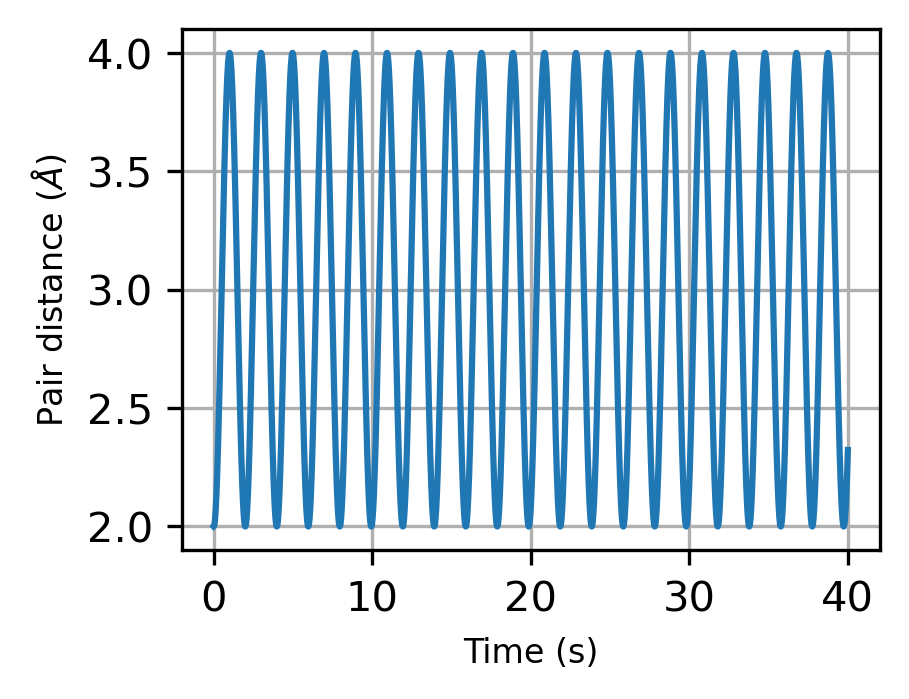

In [27]:
# Parameters
m1, m2 = 1.0, 1.0  # masses of the balls
k_values = [5.0]  # spring constant for the single spring
natural_lengths = [2.0]  # natural length of the single spring
initial_positions = [1.5, 2.5]  # initial positions of Ball_1 and Ball_2
initial_velocities = [0, 0]  # initial velocities
dt = 0.01  # time step
n_steps = 4000  # number of time steps

# Function to calculate the acceleration
def calculate_acceleration(x1, x2, k_values, natural_lengths, m1, m2):
    # Calculate spring force
    f1 = -k_values[0] * (x1 - x2 + natural_lengths[0])
    f2 = -f1  # Newton's third law
    
    # Calculate accelerations
    a1 = f1 / m1
    a2 = f2 / m2
    return a1, a2

# Time integration using 4th order Runge-Kutta
positions = np.zeros((n_steps + 1, 2))
velocities = np.zeros((n_steps + 1, 2))
positions[0] = initial_positions
velocities[0] = initial_velocities

for i in range(n_steps):
    x1, x2 = positions[i]
    v1, v2 = velocities[i]

    # Calculate k1 and l1
    a1, a2 = calculate_acceleration(x1, x2, k_values, natural_lengths, m1, m2)
    k1 = [v1 * dt, v2 * dt]
    l1 = [a1 * dt, a2 * dt]
    
    # Calculate k2 and l2
    a1, a2 = calculate_acceleration(x1 + 0.5 * k1[0], x2 + 0.5 * k1[1], k_values, natural_lengths, m1, m2)
    k2 = [(v1 + 0.5 * l1[0]) * dt, (v2 + 0.5 * l1[1]) * dt]
    l2 = [a1 * dt, a2 * dt]
    
    # Calculate k3 and l3
    a1, a2 = calculate_acceleration(x1 + 0.5 * k2[0], x2 + 0.5 * k2[1], k_values, natural_lengths, m1, m2)
    k3 = [(v1 + 0.5 * l2[0]) * dt, (v2 + 0.5 * l2[1]) * dt]
    l3 = [a1 * dt, a2 * dt]
    
    # Calculate k4 and l4
    a1, a2 = calculate_acceleration(x1 + k3[0], x2 + k3[1], k_values, natural_lengths, m1, m2)
    k4 = [(v1 + l3[0]) * dt, (v2 + l3[1]) * dt]
    l4 = [a1 * dt, a2 * dt]

    # Update positions and velocities
    positions[i + 1] = positions[i] + (1/6) * (np.array(k1) + 2 * np.array(k2) + 2 * np.array(k3) + np.array(k4))
    velocities[i + 1] = velocities[i] + (1/6) * (np.array(l1) + 2 * np.array(l2) + 2 * np.array(l3) + np.array(l4))

# Calculate distance between balls
distances = positions[:, 1] - positions[:, 0]

# Plot distance vs time
fig, axs = plt.subplots(1, 1, figsize=(3, 2.3), dpi=300)
plt.plot(np.linspace(0, n_steps * dt, n_steps + 1), 1+distances)

plt.xlabel('Time (s)',fontsize=8)
plt.ylabel('Pair distance ($\AA$)',fontsize=8)
#plt.title('Distance between two balls connected by a single spring', fontsize=8)
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 16ms/step


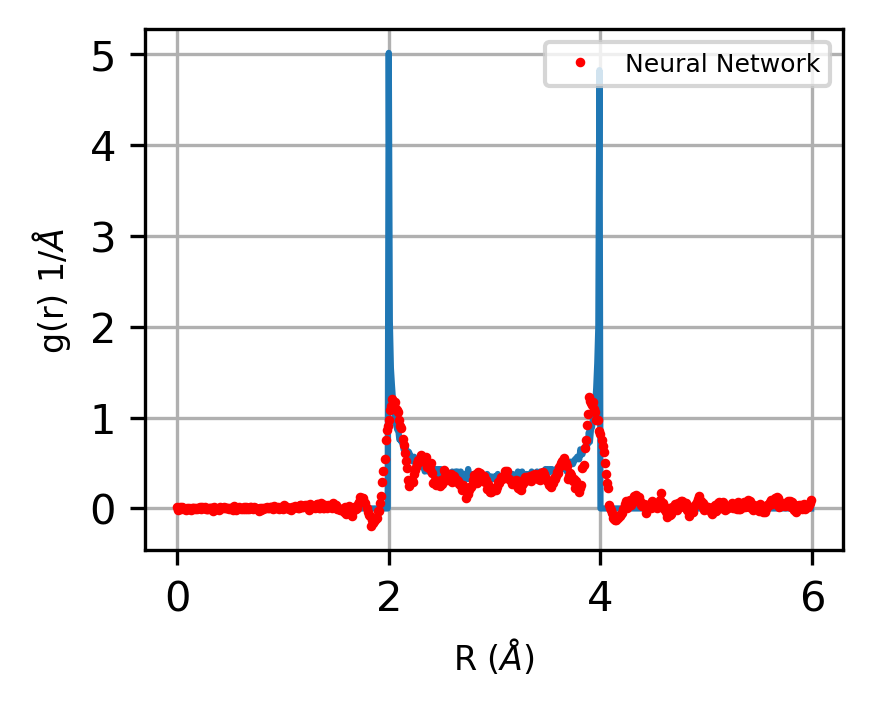

In [30]:
exafs, rdf = make_Fexafs(1+distances)
fig, axs = plt.subplots(1, 1, figsize=(3, 2.3), dpi=300)
plt.plot(rmesh, rdf)
plt.plot(dimer_mesh,model.predict(np.asarray([exafs]))[0], color='red',linestyle="None", marker="o", label='Neural Network', markersize=1.3)
plt.xlabel('R ($\AA$)', size=8)
plt.ylabel('g(r) 1/$\AA$', size=8)
plt.grid(True)
plt.legend(fontsize=6, loc='upper right')
plt.show()
